In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Dropout
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint
import pprint
from tensorflow.keras.callbacks import Callback

In [2]:
classes = ["Dos", "Normal", "Probe", "R2L", "U2R"]

In [3]:
kdd_dataset = pd.read_csv('NSL-KDD.preProcessed.csv')
np.random.seed(42)
kdd_dataset.head()

duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
0       0.0  0.173913    0.00988        0.0   0.0             0.0     0.0   
1       0.0  0.347826    0.00000        0.0   0.0             0.0     0.0   
2       0.0  0.681159    0.00000        0.0   0.0             0.0     0.0   
3       0.0  0.710145    0.00000        0.0   0.0             0.0     0.0   
4       0.0  0.710145    0.00000        0.0   0.0             0.0     0.0   

   hot  num_failed_logins  logged_in  ...  flag_S1  flag_S2  flag_S3  flag_SF  \
0  0.0                0.0        0.0  ...      0.0      0.0      0.0      1.0   
1  0.0                0.0        0.0  ...      0.0      0.0      0.0      0.0   
2  0.0                0.0        0.0  ...      0.0      0.0      0.0      0.0   
3  0.0                0.0        0.0  ...      0.0      0.0      0.0      0.0   
4  0.0                0.0        0.0  ...      0.0      0.0      0.0      0.0   

   flag_SH  label_DoS  label_Normal  label_Probe  label_R2L  label_U2R  
0      0.0        0.0           1.0          0.0        0.0        0.0  
1      0.0        1.0           0.0          0.0        0.0        0.0  
2      0.0        1.0           0.0          0.0        0.0        0.0  
3      0.0        1.0           0.0          0.0        0.0        0.0  
4      0.0        0.0           0.0          1.0        0.0        0.0  

[5 rows x 59 columns]

In [4]:
kdd_test = pd.read_csv('NSL-KDD-test.preProcessed.csv')


In [5]:
features = list(kdd_dataset)
features.remove('label_DoS')
features.remove('label_Normal')
features.remove('label_Probe')
features.remove('label_R2L')
features.remove('label_U2R')

In [6]:

DoS = kdd_dataset.loc[kdd_dataset['label_DoS'] == 1]
Normal = kdd_dataset.loc[kdd_dataset['label_Normal'] == 1]
Probe = kdd_dataset.loc[kdd_dataset['label_Probe'] == 1]
R2L = kdd_dataset.loc[kdd_dataset['label_R2L'] == 1]
U2R = kdd_dataset.loc[kdd_dataset['label_U2R'] == 1]


In [7]:
#Reduce oversampled data by a factor of 40. Same class distribution maintained after reduction.

# DoS = DoS.sample(n=97084,random_state = 42)
# Normal = Normal.sample(n=24320, random_state = 42)
# Probe = Probe.sample(n=1027, random_state=42)
# R2L = R2L.sample(n=1126, random_state=42)

DoS = DoS.sample(n=45927,random_state = 42)
Normal = Normal.sample(n=67343, random_state = 42)
Probe = Probe.sample(n=11656, random_state=42)
R2L = R2L.sample(n=995, random_state=42)


In [8]:
#Optionally oversample imbalanced classes

U2R = U2R.append([U2R]*100,ignore_index=True)
R2L = R2L.append([R2L]*5,ignore_index=True)

In [9]:
reduced_dataset = pd.concat([DoS,Normal,Probe,R2L,U2R])
kdd_dataset = reduced_dataset.sample(n=len(reduced_dataset), random_state = 42)

In [10]:

x = kdd_dataset[features].values
y = kdd_dataset.iloc[:,54:].values
print("number of datapoints = {} and number of features = {}".format(len(x),len(x[0])))

number of datapoints = 133118 and number of features = 54


In [11]:
train_up_dic = {
            1: 67373,
            0: 45927,
            2: 15000,          # 11656 -> 15000
            3: 15000,            # 995 -> 15000
            4: 15000             # 52 -> 15000
        }
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=train_up_dic, random_state=42)
print("Before resample:")
for i in range(0,5):
    ii = 0
    for y_ in y:
        if y_[i] == 1:
            ii += 1
    print("Number of {}: {}".format(classes[i], ii))
x_res, y_res = sm.fit_resample(x,y)
print("After resample:")
for i in range(0,5):
    ii = 0
    for y_ in y_res:
        if y_[i] == 1:
            ii += 1
    print("Number of {}: {}".format(classes[i], ii))

Before resample:
Number of Dos: 45927
Number of Normal: 67343
Number of Probe: 11656
Number of R2L: 5970
Number of U2R: 2222


/home/hieuhv/.local/lib/python3.6/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (67373) in class 1 will be larger than the number of samples in the majority class (class #1 -> 67343)
  f"After over-sampling, the number of samples ({n_samples})"


After resample:
Number of Dos: 45927
Number of Normal: 67373
Number of Probe: 15000
Number of R2L: 15000
Number of U2R: 15000


In [12]:
# Counting occurrences
from collections import Counter
print(Counter([tuple(x) for x in y]))

Counter({(0.0, 1.0, 0.0, 0.0, 0.0): 67343, (1.0, 0.0, 0.0, 0.0, 0.0): 45927, (0.0, 0.0, 1.0, 0.0, 0.0): 11656, (0.0, 0.0, 0.0, 1.0, 0.0): 5970, (0.0, 0.0, 0.0, 0.0, 1.0): 2222})


In [13]:
#PCA

print("Shape before transformation - {}".format(np.asarray(x_res).shape))
pca = decomposition.PCA(n_components=10)
pca.fit(x_res)
x_pca = pca.transform(x_res)
print("Shape after transformation - {}".format(x_pca.shape))
x_pca = x_pca.tolist()



Shape before transformation - (158300, 54)
Shape after transformation - (158300, 10)


In [14]:
X_test = pca.transform(kdd_test[features].values)
Y_test = kdd_test.iloc[:,54:].values
print(len(X_test))

22544


In [15]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_tr, X_val, Y_tr, Y_val = train_test_split(x_pca, y_res,
                                                    stratify=y_res, 
                                                    test_size=0.2,
                                                    random_state=42)


In [16]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_tr, Y_tr,
#                                                     stratify=Y_tr, 
#                                                     test_size=0.25,
#                                                     random_state=42)
# max_len = len(X_train)

In [17]:
def processTrainTestArrays(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    x = np.reshape(x, (x.shape[0], x.shape[1],1))
    y=np.reshape(y, (y.shape[0], y.shape[1]))
    return x,y

In [18]:
def onehotencode(y):
    from keras.utils.np_utils import to_categorical
    y_binary = to_categorical(y)
    return y_binary

In [19]:
# define model
def create_model(X_train,Y_train, number_of_units):
    Batch_size = 1
    randomInit = initializers.RandomUniform(seed=42)
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    
    model = Sequential()
    #model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,
    #               batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2]),return_sequences=True))
    #model.add(Dropout(0.1))
    #model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,
    #               batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2]),return_sequences=True))
    #model.add(Dropout(0.1))
    model.add(GRU(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,
                   batch_input_shape=(Batch_size,X_train.shape[1], X_train.shape[2])))
    #model.add(Dropout(0.1))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    
    nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

    print(model.summary())
    return model

In [20]:
def compute_metrics(predicted, Y_test):
   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    gt_classes = [np.argmax(item) for item in Y_test]
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(gt_classes, predicted_classes, normalize='all')

    cmd = ConfusionMatrixDisplay(cm, display_labels=['Dos','Normal','Probe','R2L','U2R'])
    cmd.plot()
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=[0,1,2,3,4])
    y_pre = pd.Categorical(y_pred, categories=[0,1,2,3,4])
    
    #F1 score
    from sklearn.metrics import f1_score,precision_score, recall_score
    for ii in range(0,5):
        print("----- {} -------".format(classes[ii]))
        print(" Precesion score is {}".format(precision_score(Y_classes, predicted_classes, average=None, labels = [ii])))
        print(" Recall score is {}".format(recall_score(Y_classes, predicted_classes, average=None, labels = [ii])))
        print(" F1 score is {}".format(f1_score(Y_classes, predicted_classes, average=None, labels = [ii])))

        # print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [ii])))
    # print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [1])))
    # print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [2])))
    # print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [3])))
    # print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = [4])))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 5
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [21]:
#checkpoint save weights
#Y_train

hdf5FileName = "bestWeightsGRUStateless3L50_NSL.hdf5"
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

In [22]:
#Time to train

Batch_size=1
start_time = time.time()

x_train,y_train = processTrainTestArrays(X_tr,Y_tr)
x_val,y_val = processTrainTestArrays(X_val,Y_val)
model = create_model(x_train,y_train, 50)


model.fit(x_train, y_train, epochs=15, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (x_val,y_val),callbacks=[checkpoint])  

print("--- %s seconds ---" % (time.time() - start_time))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, 50)                   7800      
_________________________________________________________________
dense (Dense)                (1, 5)                    255       
Total params: 8,055
Trainable params: 8,055
Non-trainable params: 0
_________________________________________________________________
None
--- 0.4411437511444092 seconds ---



Time for testing

Optimal weights loaded from file bestWeightsGRUStateless3L50_NSL.hdf5
Model Successfully compiled with loaded weights

22544/22544 [==============================] - 21s 924us/sample - loss: 1.8890 - acc: 0.7668
Loss for testing = 1.889029210327953 and Accuracy for testing = 0.7667672038078308
----- Dos -------
 Precesion score is [0.82893858]
 Recall score is [0.86518028]
 F1 score is [0.84667178]
----- Normal -------
 Precesion score is [0.81449072]
 Recall score is [0.86306654]
 F1 score is [0.83807534]
----- Probe -------
 Precesion score is [0.26641112]
 Recall score is [0.50271248]
 F1 score is [0.34826182]
----- R2L -------
 Precesion score is [0.96969697]
 Recall score is [0.05820828]
 F1 score is [0.10982411]
----- U2R -------
 Precesion score is [0.]
 Recall score is [0.]
 F1 score is [0.]
Confusion matrix: 
 Predicted     0      1     2    3   4
Actual                               
0          4967    482   288    0   4
1           584  11635  1223    4  3

/home/hieuhv/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


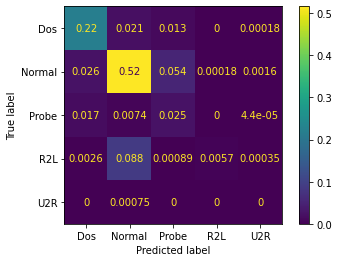

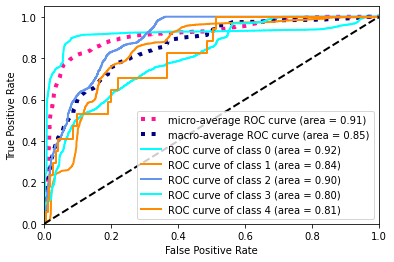

In [23]:
#Test with best model
#Load weights and compile again
print("\n===========================\nTime for testing\n===========================\n")
model.load_weights(hdf5FileName)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print("Optimal weights loaded from file {}".format(hdf5FileName))
print("Model Successfully compiled with loaded weights\n")

#Do same preprocessing for test data
x_test,y_test = processTrainTestArrays(X_test,Y_test)
loss,acc = model.evaluate(x_test,y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
predicted = model.predict(x_test,batch_size=Batch_size)
compute_metrics(predicted, y_test)  